In [3]:
file_folder = Path('C:/Users/ilkele4s/LSTM_electrodes')
print(file_folder)

C:\Users\ilkele4s\LSTM_electrodes


In [45]:
cur_el = joblib.load('it.sav')

In [46]:
File = 'electrode_' +str(cur_el) + '.csv'
file_path = os.path.join(file_folder,File)
print(file_path)

C:\Users\ilkele4s\LSTM_electrodes\electrode_2.csv


In [6]:
NewDirectory = 'electrode_' +str(cur_el) 
os.mkdir(os.path.join(file_folder,NewDirectory))

NewDirectory = os.path.join(file_folder,NewDirectory)

In [7]:
# load the data (samples only)

data_samples = pd.read_csv(file_path, header = None)

In [8]:
# structure samples for LSTM

data_array = np.array(data_samples)

n_samples = data_array.shape[0]
n_features = data_array.shape[1]

bin_cur = 1
bin_past = 3

bins_predict = bin_cur + bin_past # 3 previous + 1 current

formatted_data = np.zeros([n_samples,bins_predict,n_features])

start_idx=0
for i in range(n_samples-bin_past):
    end_idx=start_idx+bins_predict
    formatted_data[i+bin_past,:,:]=data_array[start_idx:end_idx,:]
    start_idx=start_idx+1

In [9]:
print(n_features)

300


In [10]:
# create a label set

n_zones = 45
n_trials = 32


cat_zones = keras.utils.to_categorical(np.r_[1:n_zones+1] ,num_classes=46)
cat_zones = np.delete(cat_zones,0,1)
labels_all_trials = np.tile(cat_zones, 32)

reshaped_labels_all_trials = np.reshape(labels_all_trials, [1440,45])



In [11]:
# test - validation - train split (20/20/60)

all_ind = np.random.choice(np.arange(0, n_samples, 1), n_samples)

test_ind = all_ind[:int(n_samples/5)] # 20

validation_ind = all_ind[int(n_samples/5):int(n_samples/5+n_samples/5)] # 20 

train_ind = all_ind[int(n_samples/5+n_samples/5):] # 60


In [12]:
print(np.shape(test_ind))
print(np.shape(validation_ind))
print(np.shape(train_ind))

(288,)
(288,)
(864,)


In [13]:
test_samples = formatted_data[test_ind,:,:]
test_labels = reshaped_labels_all_trials[test_ind,:]

train_samples = formatted_data[train_ind,:,:]
train_labels = reshaped_labels_all_trials[train_ind,:]

validation_samples = formatted_data[validation_ind,:,:]
validation_labels = reshaped_labels_all_trials[validation_ind,:]

In [14]:
train_samples[np.isnan(train_samples)] = 0
test_samples[np.isnan(test_samples)] = 0
validation_samples[np.isnan(validation_samples)] = 0

In [15]:
print(np.shape(test_samples))
print(np.shape(train_samples))
print(np.shape(validation_samples))

print(np.shape(test_labels))
print(np.shape(train_labels))
print(np.shape(validation_labels))

(288, 4, 300)
(864, 4, 300)
(288, 4, 300)
(288, 45)
(864, 45)
(288, 45)


In [16]:
joblib.dump(train_samples, os.path.join(NewDirectory,'train_samples.sav'))
joblib.dump(train_labels, os.path.join(NewDirectory,'train_labels.sav'))

joblib.dump(test_samples, os.path.join(NewDirectory,'test_samples.sav'))
joblib.dump(test_labels, os.path.join(NewDirectory,'test_labels.sav'))

joblib.dump(validation_samples, os.path.join(NewDirectory,'validation_samples.sav'))
joblib.dump(validation_labels, os.path.join(NewDirectory,'validation_labels.sav'))

['C:\\Users\\ilkele4s\\LSTM_electrodes\\electrode_1\\validation_labels.sav']

In [17]:
class MyHyperModel(kt.HyperModel):

    def build(self,hp):
        
            LSTM_units = [30, 40, 50]
            Drop_rate = [.20, .30, .40]
            RecDrop_rate = [.20, .30, .40]
            learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

            model=Sequential()
            model.add(Masking(mask_value=0, input_shape=(4, n_features))),
            model.add(LSTM(hp.Choice('LSTM_units',LSTM_units),                
                           input_shape=(4, n_features), 
                           dropout=hp.Choice('Drop_rate',Drop_rate),
                           recurrent_dropout=hp.Choice('RecDrop_rate', RecDrop_rate)))

            model.add(Dense(45, activation='softmax'))
            model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['accuracy'])

            return model 
        
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )




In [18]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective =kt.Objective("val_loss", direction="min"),
    overwrite=True,
    max_trials=30,
    directory= NewDirectory ,
    project_name="tune_hypermodel",
)



In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
LSTM_units (Choice)
{'default': 30, 'conditions': [], 'values': [30, 40, 50], 'ordered': True}
Drop_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
RecDrop_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}


In [20]:
tuner.search(train_samples, train_labels, epochs=20, validation_data=(validation_samples, validation_labels))

Trial 30 Complete [00h 00m 10s]
val_loss: 3.6753315925598145

Best val_loss So Far: 1.3209346532821655
Total elapsed time: 00h 04m 51s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.results_summary(num_trials=3)

Results summary
Results in C:\Users\ilkele4s\LSTM_electrodes\electrode_1\tune_hypermodel
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 09 summary
Hyperparameters:
lr: 0.008890059865167516
LSTM_units: 50
Drop_rate: 0.2
RecDrop_rate: 0.3
shuffle: False
Score: 1.3209346532821655

Trial 17 summary
Hyperparameters:
lr: 0.00483404618006194
LSTM_units: 40
Drop_rate: 0.2
RecDrop_rate: 0.2
shuffle: False
Score: 1.4274002313613892

Trial 08 summary
Hyperparameters:
lr: 0.004823073949081142
LSTM_units: 40
Drop_rate: 0.3
RecDrop_rate: 0.2
shuffle: False
Score: 1.5482888221740723


In [22]:
# Capture the printed output using io.StringIO
summary_output = io.StringIO()

# Use contextlib.redirect_stdout to redirect the print output to the StringIO object
with contextlib.redirect_stdout(summary_output):
    tuner.results_summary(num_trials=3)

# Get the captured output
summary_text = summary_output.getvalue()


In [23]:
file = open(os.path.join(NewDirectory,'best_3params.txt'), 'w')
# Write content to the file
file.write(summary_text)

601

In [24]:
best_hyperparameters = tuner.get_best_hyperparameters()

In [25]:
directory_path = os.path.join(NewDirectory,'tune_hypermodel')

# Define a pattern to match files with names like "trial1", "trial2", etc.

pattern = "trial*"

# Use glob to find matching files
matching_files = glob.glob(os.path.join(directory_path, pattern))

# Iterate over matching files and delete them
for file_path in matching_files:
    try:
        shutil.rmtree(file_path)
        print(f"File '{file_path}' deleted successfully.")
    except OSError as e:
        print(f"Error deleting '{file_path}': {e}")

File 'C:\Users\ilkele4s\LSTM_electrodes\electrode_1\tune_hypermodel\trial_00' deleted successfully.
File 'C:\Users\ilkele4s\LSTM_electrodes\electrode_1\tune_hypermodel\trial_01' deleted successfully.
File 'C:\Users\ilkele4s\LSTM_electrodes\electrode_1\tune_hypermodel\trial_02' deleted successfully.
File 'C:\Users\ilkele4s\LSTM_electrodes\electrode_1\tune_hypermodel\trial_03' deleted successfully.
File 'C:\Users\ilkele4s\LSTM_electrodes\electrode_1\tune_hypermodel\trial_04' deleted successfully.
File 'C:\Users\ilkele4s\LSTM_electrodes\electrode_1\tune_hypermodel\trial_05' deleted successfully.
File 'C:\Users\ilkele4s\LSTM_electrodes\electrode_1\tune_hypermodel\trial_06' deleted successfully.
File 'C:\Users\ilkele4s\LSTM_electrodes\electrode_1\tune_hypermodel\trial_07' deleted successfully.
File 'C:\Users\ilkele4s\LSTM_electrodes\electrode_1\tune_hypermodel\trial_08' deleted successfully.
File 'C:\Users\ilkele4s\LSTM_electrodes\electrode_1\tune_hypermodel\trial_09' deleted successfully.


In [26]:
def build_model(hp):
    model_opt=Sequential()
    model_opt.add(Masking(mask_value=0, input_shape=(4, n_features)))
    model_opt.add(LSTM(50,input_shape=(4, n_features),dropout=.30,recurrent_dropout=.40))
    model_opt.add(Dense(45, activation='softmax'))

    model_opt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model_opt


In [27]:
best_model = build_model(best_hyperparameters)

In [28]:
joblib.dump(best_model, os.path.join(NewDirectory,'best_model.sav'))

['C:\\Users\\ilkele4s\\LSTM_electrodes\\electrode_1\\best_model.sav']

In [29]:
best_model_trained = best_model.fit(train_samples, train_labels,validation_data=(validation_samples, validation_labels),
                      epochs = 100, verbose=1)

Epoch 1/100
27/27 [==============================] - 3s 24ms/step - loss: 3.7848 - accuracy: 0.0394 - val_loss: 3.7671 - val_accuracy: 0.0660
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 3.6866 - accuracy: 0.1111 - val_loss: 3.7210 - val_accuracy: 0.0868
Epoch 3/100
27/27 [==============================] - 0s 9ms/step - loss: 3.6035 - accuracy: 0.1597 - val_loss: 3.6730 - val_accuracy: 0.1007
Epoch 4/100
27/27 [==============================] - 0s 9ms/step - loss: 3.5052 - accuracy: 0.2025 - val_loss: 3.6082 - val_accuracy: 0.1250
Epoch 5/100
27/27 [==============================] - 0s 9ms/step - loss: 3.3894 - accuracy: 0.2512 - val_loss: 3.5338 - val_accuracy: 0.1250
Epoch 6/100
27/27 [==============================] - 0s 9ms/step - loss: 3.2814 - accuracy: 0.2882 - val_loss: 3.4681 - val_accuracy: 0.1424
Epoch 7/100
27/27 [==============================] - 0s 9ms/step - loss: 3.1464 - accuracy: 0.3067 - val_loss: 3.3857 - val_accuracy: 0.1562
Epoch 8/100


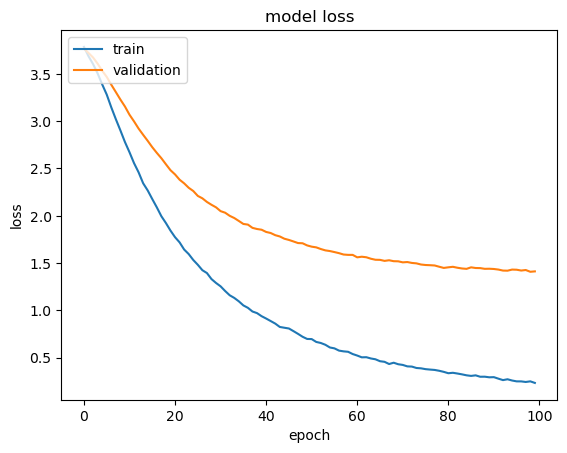

In [41]:
plt.plot(best_model_trained.history['loss'])
plt.plot(best_model_trained.history['val_loss'])

plt.legend(['train', 'validation'], loc='upper left')

ay = plt.gca()

ay.yaxis.set_major_locator(MultipleLocator(base=0.50)) 


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.savefig(os.path.join(NewDirectory,'Model_loss.png'))
plt.show()

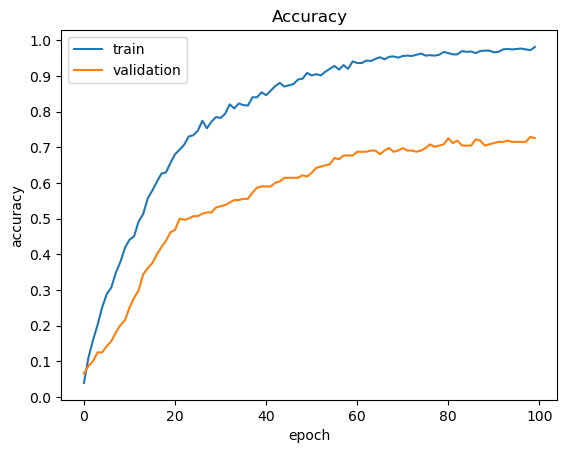

In [40]:
plt.plot(best_model_trained.history['accuracy'])
plt.plot(best_model_trained.history['val_accuracy'])


ay = plt.gca()
ay.yaxis.set_major_locator(MultipleLocator(base=0.10)) 

plt.legend(['train', 'validation'], loc='upper left')

plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.savefig(os.path.join(NewDirectory,'Model_accuracy.png'))
plt.show()

In [42]:
predictions = best_model.predict(test_samples)
#%%
predicted_labels = np.argmax(predictions, axis=1) + 1
#%%
true_label = np.argmax(test_labels, axis=1) + 1
#%%


9/9 [==============================] - 0s 3ms/step


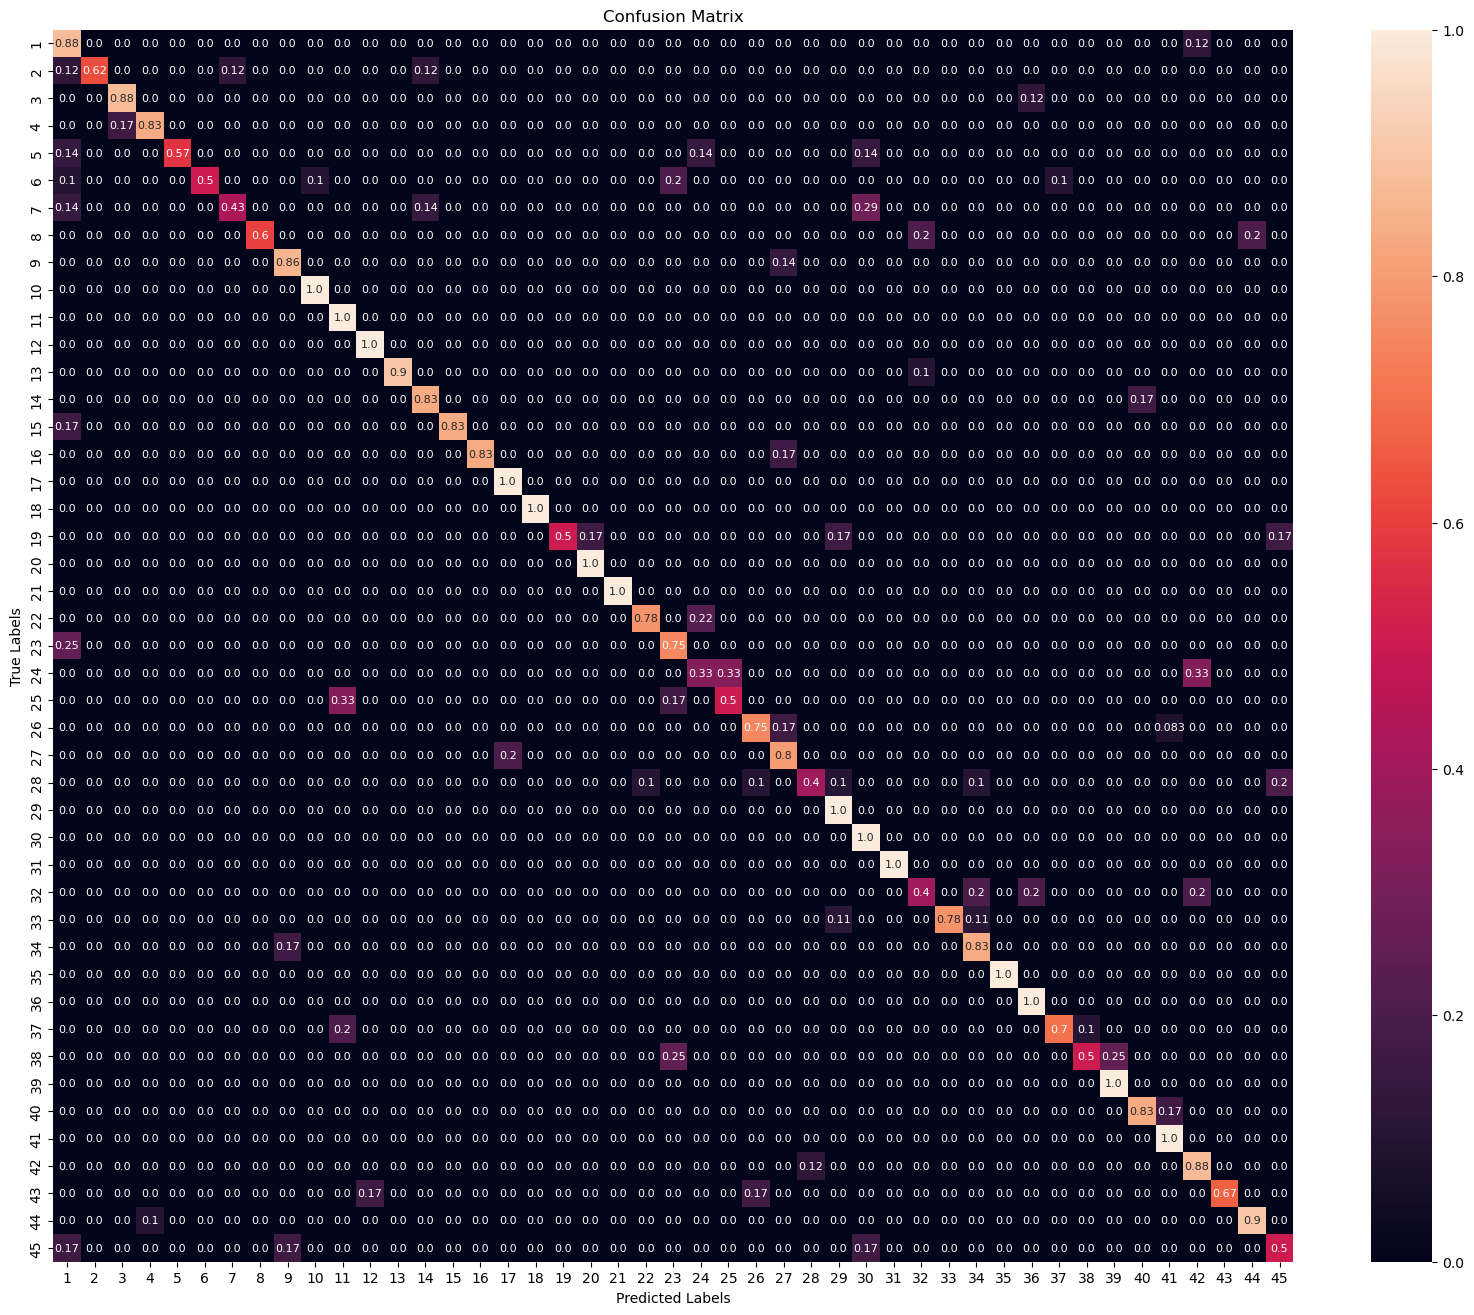

In [43]:

#%%
cm = confusion_matrix(true_label, predicted_labels, normalize='true')
#%%
class_labels = [str(i) for i in range(1, 46)]
#%%
plt.figure(figsize=(20, 16))
sns.heatmap(cm, fmt='.2',annot=True, annot_kws={"size": 8}, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig(os.path.join(NewDirectory,'Cm_optim.png'))
plt.show()

In [44]:
del tuner
del best_model